# Emotion Dataset — EDA & Preprocessing Checks

This notebook inspects split sizes and class balance, validates image paths, and previews a few images.


In [2]:
import os
import pandas as pd 
import matplotlib.pyplot as plt

# Raw Dataset — FullDataEmoSet (EDA)

This section analyzes the raw dataset folder structure and images directly, without relying on precomputed splits.

It covers:
- Total images and number of classes
- Per-class counts and percentages
- Descriptive statistics of per-class frequencies
- Image integrity (readability) check
- Pixel statistics (width, height, area, aspect ratio) and basic plots


In [3]:
# Setup paths and imports for raw dataset scan
import os
import json
from pathlib import Path
from collections import Counter

import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt

RAW_ROOT = Path("../data/raw/FullDataEmoSet").resolve()
assert RAW_ROOT.exists(), f"Raw dataset folder not found: {RAW_ROOT}"

# Treat each immediate subfolder as a class label
class_dirs = [p for p in RAW_ROOT.iterdir() if p.is_dir()]
labels = sorted([p.name for p in class_dirs])
print(f"Found {len(labels)} classes: {labels}")

Found 6 classes: ['angry', 'fearful', 'happy', 'neutral', 'sad', 'surprised']


In [10]:
# Index images and validate readability
try:
    from tqdm import tqdm  # type: ignore
except Exception:
    def tqdm(iterable, **kwargs):
        return iterable

IMG_EXTS = {".jpg", ".jpeg", ".png", ".bmp", ".gif"}

records = []
bad_images = []
for lab in labels:
    img_paths = sorted([p for p in (RAW_ROOT / lab).rglob('*') if p.suffix.lower() in IMG_EXTS])
    if MAX_IMAGES_PER_CLASS is not None:
        img_paths = img_paths[:int(MAX_IMAGES_PER_CLASS)]
    for p in tqdm(img_paths, desc=f"Scanning {lab}"):
        fmt = None
        mode = None
        try:
            with Image.open(p) as im:
                im.verify()  # Quick check
                fmt = im.format
                mode = im.mode
            with Image.open(p) as im2:
                w, h = im2.size
        except Exception as e:
            bad_images.append({"path": str(p), "label": lab, "error": str(e)})
            continue
        records.append({
            "path": str(p),
            "label": lab,
            "width": w,
            "height": h,
            "area": w * h,
            "aspect": w / h if h else np.nan,
            "format": fmt,
            "mode": mode,
        })

raw_df = pd.DataFrame(records)
print(f"Indexed {len(raw_df)} readable images; bad images: {len(bad_images)}")
if bad_images:
    bad_df = pd.DataFrame(bad_images)
    display(bad_df.head())

Scanning surprised: 100%|██████████| 4936/4936 [00:00<00:00, 10321.85it/s]


Indexed 43640 readable images; bad images: 0


In [11]:
# Overall counts and class distribution
print(f"Total images: {len(raw_df)} | Classes: {len(labels)}")

class_counts = raw_df['label'].value_counts().sort_index()
print("\nCounts per class:\n", class_counts)

percentages = (class_counts / class_counts.sum() * 100).round(2)
print("\nPercentages per class (%):\n", percentages)

print("\nDescriptive statistics of class counts:")
print(class_counts.describe())

Total images: 43640 | Classes: 6

Counts per class:
 label
angry         4953
fearful       4245
happy        13365
neutral       8324
sad           7817
surprised     4936
Name: count, dtype: int64

Percentages per class (%):
 label
angry        11.35
fearful       9.73
happy        30.63
neutral      19.07
sad          17.91
surprised    11.31
Name: count, dtype: float64

Descriptive statistics of class counts:
count        6.000000
mean      7273.333333
std       3421.279098
min       4245.000000
25%       4940.250000
50%       6385.000000
75%       8197.250000
max      13365.000000
Name: count, dtype: float64


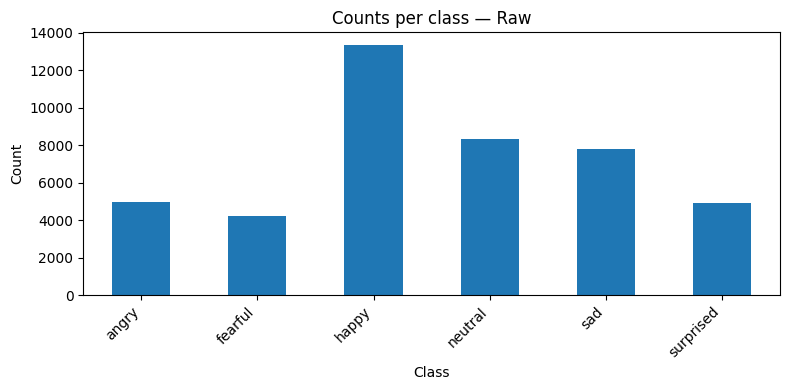

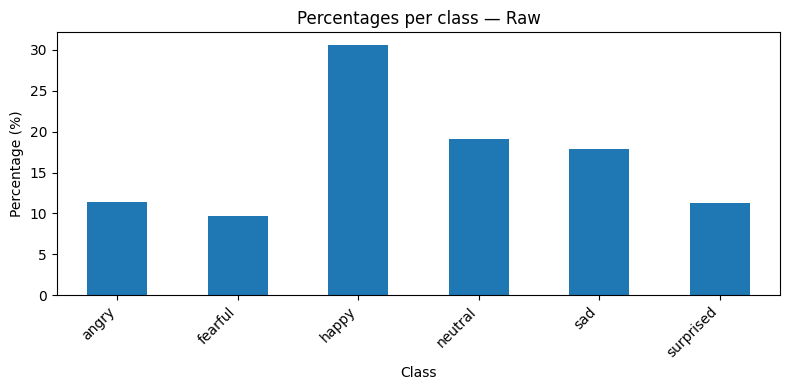


Pixel statistics (width/height/area/aspect):
              width        height           area        aspect
count  43640.000000  43640.000000   43640.000000  43640.000000
mean      74.591132     74.588497   10541.071952      1.000001
std       70.565039     70.540866   45021.813971      0.001215
min       48.000000     48.000000    2304.000000      0.922330
25%       48.000000     48.000000    2304.000000      1.000000
50%       48.000000     48.000000    2304.000000      1.000000
75%      100.000000    100.000000   10000.000000      1.000000
max      640.000000    640.000000  409600.000000      1.080205


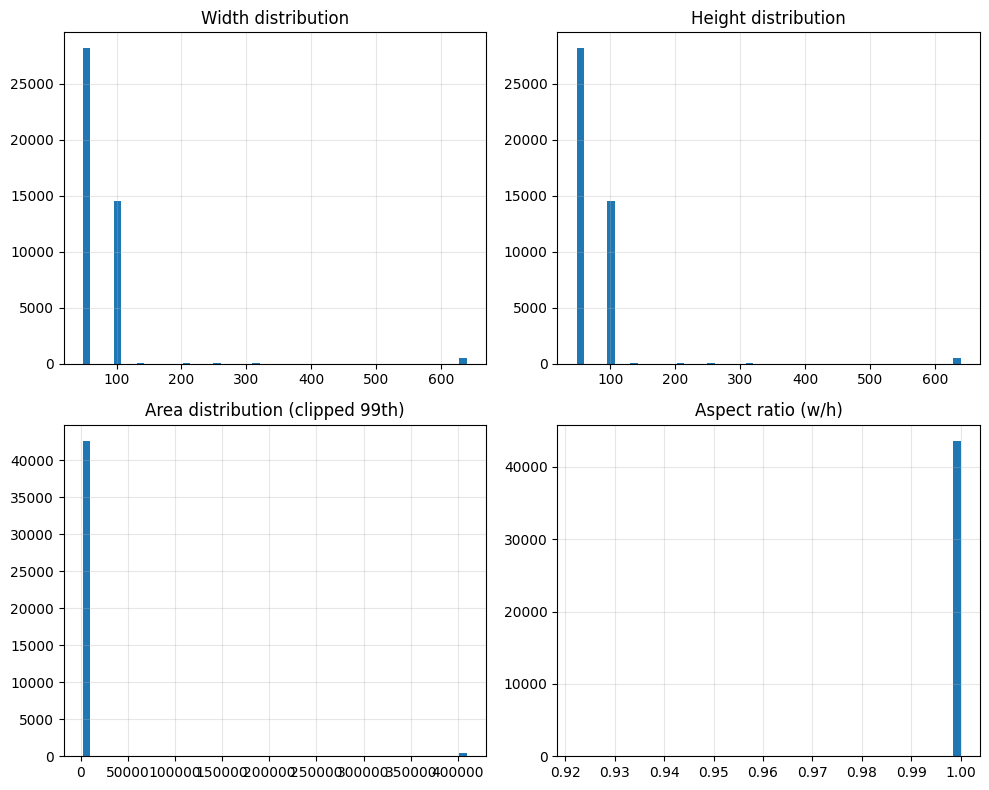

In [12]:
# Plots for counts and percentages
plt.figure(figsize=(8,4))
class_counts.plot(kind='bar')
plt.title('Counts per class — Raw')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

plt.figure(figsize=(8,4))
percentages.plot(kind='bar')
plt.title('Percentages per class — Raw')
plt.xlabel('Class')
plt.ylabel('Percentage (%)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Pixel statistics summaries
print("\nPixel statistics (width/height/area/aspect):")
print(raw_df[['width','height','area','aspect']].describe())

fig, axes = plt.subplots(2, 2, figsize=(10,8))
axes = axes.ravel()
axes[0].hist(raw_df['width'].dropna(), bins=50)
axes[0].set_title('Width distribution')
axes[1].hist(raw_df['height'].dropna(), bins=50)
axes[1].set_title('Height distribution')
axes[2].hist(raw_df['area'].clip(upper=raw_df['area'].quantile(0.99)).dropna(), bins=50)
axes[2].set_title('Area distribution (clipped 99th)')
axes[3].hist(raw_df['aspect'].dropna().clip(upper=raw_df['aspect'].quantile(0.99)), bins=50)
axes[3].set_title('Aspect ratio (w/h)')
for ax in axes:
    ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

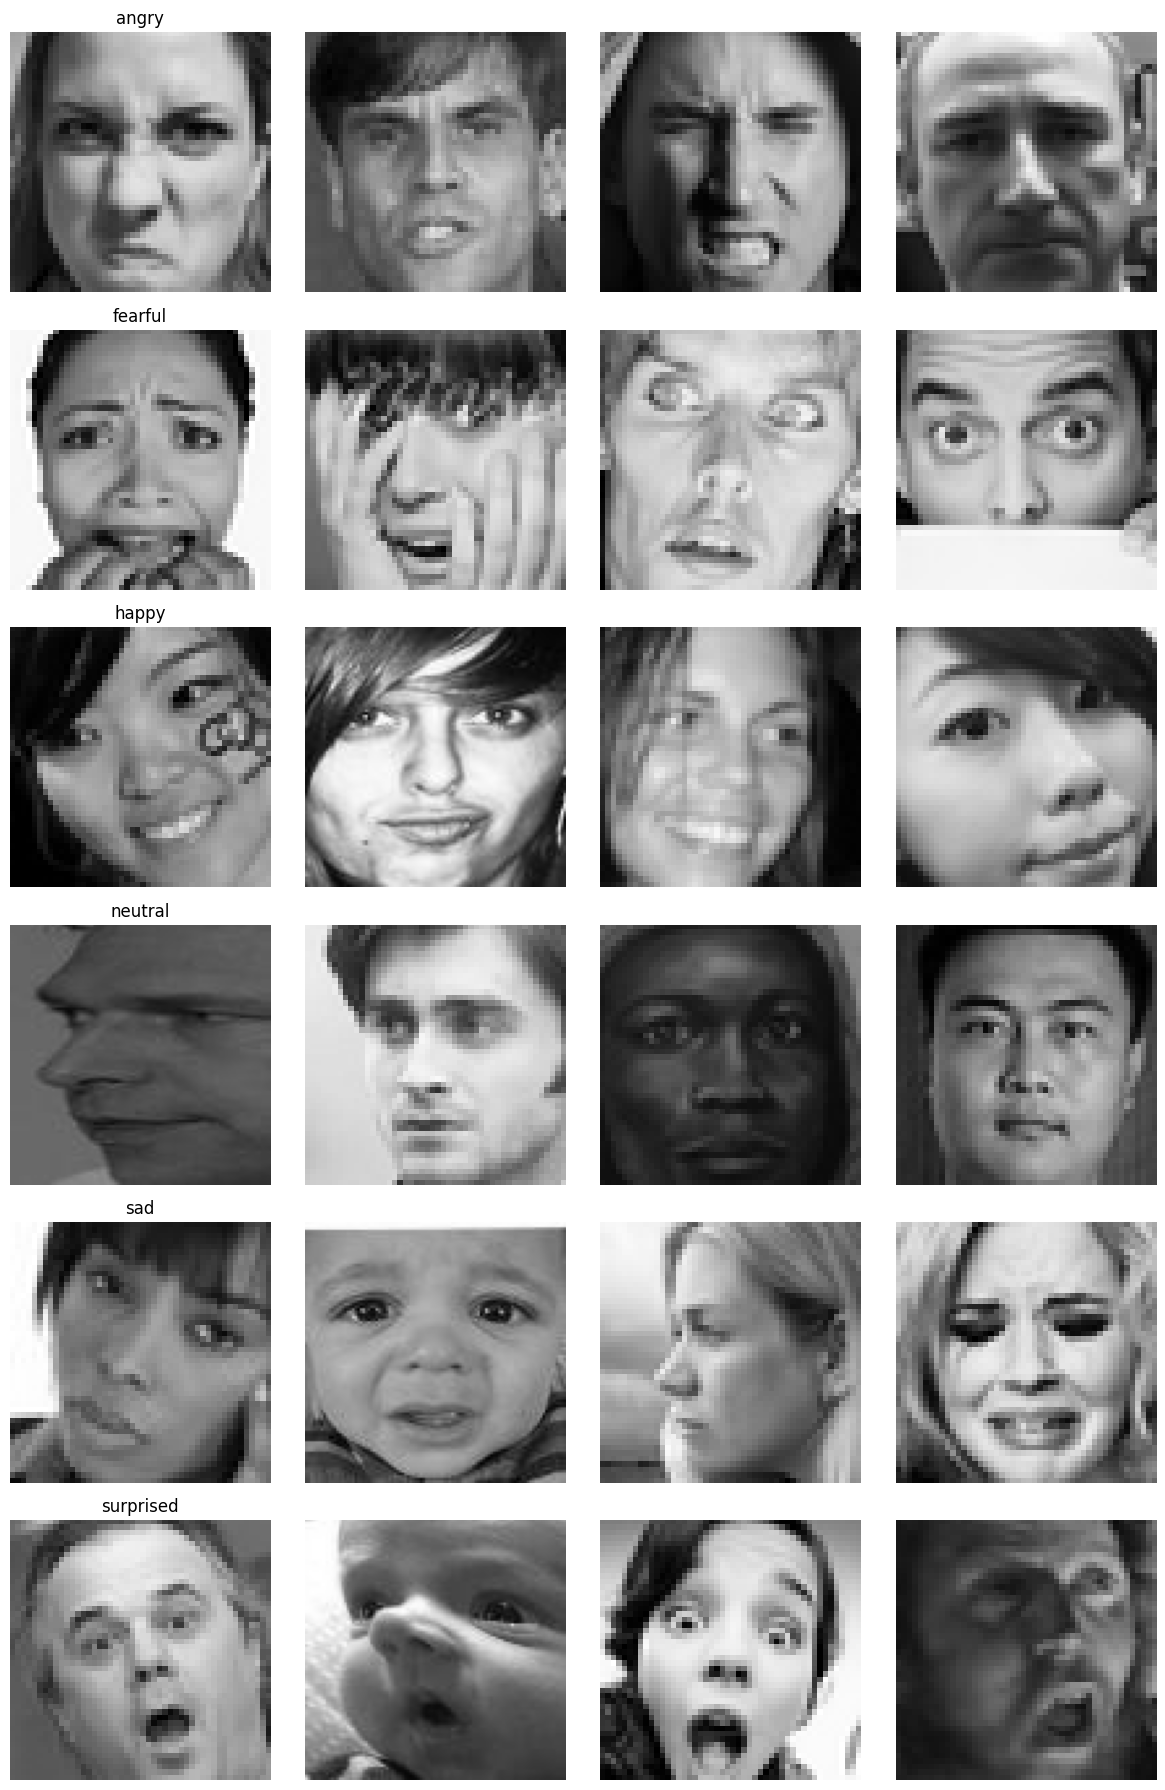

In [7]:
# Preview a few images per class
from math import ceil

samples_per_class = 4
max_classes_to_show = min(6, len(labels))
show_labels = labels[:max_classes_to_show]

fig, axes = plt.subplots(max_classes_to_show, samples_per_class, figsize=(3*samples_per_class, 3*max_classes_to_show))
if max_classes_to_show == 1:
    axes = np.array([axes])

for i, lab in enumerate(show_labels):
    subset = raw_df[raw_df['label'] == lab].sample(n=min(samples_per_class, len(raw_df[raw_df['label']==lab])), random_state=42)
    for j in range(samples_per_class):
        ax = axes[i, j]
        ax.axis('off')
        if j < len(subset):
            p = subset.iloc[j]['path']
            try:
                img = Image.open(p).convert('RGB')
                ax.imshow(img)
                ax.set_title(lab if j == 0 else '')
            except Exception:
                ax.text(0.5, 0.5, 'ERR', ha='center', va='center')
        else:
            ax.text(0.5, 0.5, '—', ha='center', va='center')
plt.tight_layout()
plt.show()

In [13]:
# Image mode/format distribution and quality checks
mode_counts = raw_df['mode'].value_counts(dropna=False)
format_counts = raw_df['format'].value_counts(dropna=False)
print("Mode counts:\n", mode_counts)
print("\nFormat counts:\n", format_counts)

# flag small images and extreme aspect ratios
MIN_W, MIN_H = 32, 32
ASPECT_MIN, ASPECT_MAX = 0.5, 2.0
small_imgs = raw_df[(raw_df['width'] < MIN_W) | (raw_df['height'] < MIN_H)]
extreme_aspect = raw_df[(raw_df['aspect'] < ASPECT_MIN) | (raw_df['aspect'] > ASPECT_MAX)]

print(f"\nSmall images (<{MIN_W}x{MIN_H}): {len(small_imgs)}")
print(f"Extreme aspect ratio (<{ASPECT_MIN} or >{ASPECT_MAX}): {len(extreme_aspect)}")

if len(small_imgs):
    display(small_imgs.head())
if len(extreme_aspect):
    display(extreme_aspect.head())

Mode counts:
 mode
L    43640
Name: count, dtype: int64

Format counts:
 format
PNG     28158
JPEG    15482
Name: count, dtype: int64

Small images (<32x32): 0
Extreme aspect ratio (<0.5 or >2.0): 0
